# Face Recognition

In [29]:
import os

import cv2

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Data Exploration

In [16]:
face_cascades = cv2.CascadeClassifier(cv2.haarcascades+'haarcascade_frontalface_default.xml')

In [12]:
def detect_faces(img, draw_box=True):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor=1.6)
    
    for (x, y, width, height) in faces:
        if draw_box:
            cv2.rectangle(img, (x, y), (x+width, y+height), (0, 255, 0), 5)
    face_box = img[y:y+height, x:x+width]
    face_coords = [x, y, width, height]
    return img, face_box, face_coords

In [13]:
path = 'C:\\Users\\Rebs\\Documents\\Dev\\nnwithpython-class\\Chapter07\\sample_faces'

In [17]:
files = os.listdir(path)
images = [file for file in files if 'jpg' in file]
for image in images:
    img = cv2.imread(path + '\\' + image)
    detected_faces, _, _ = detect_faces(img)
    cv2.imwrite(path + '\\detected_faces\\' + image, detected_faces)

## Pre-processing

In [19]:
path = 'C:\\Users\\Rebs\\Documents\\Dev\\nnwithpython-class\\Chapter07\\att_faces\\'

In [22]:
x_train, y_train = [], []
x_test, y_test = [], []

In [23]:
subfolders = sorted(f.path for f in os.scandir(path) if f.is_dir())

In [25]:
for idx, folder in enumerate(subfolders):
    for file in sorted(os.listdir(folder)):
        img = load_img(folder+'/'+file, color_mode='grayscale')
        img = img_to_array(img).astype('float32')/255
        if idx < 35:
            x_train.append(img)
            y_train.append(idx)
        else:
            x_test.append(img)
            y_test.append(idx-35)

In [27]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

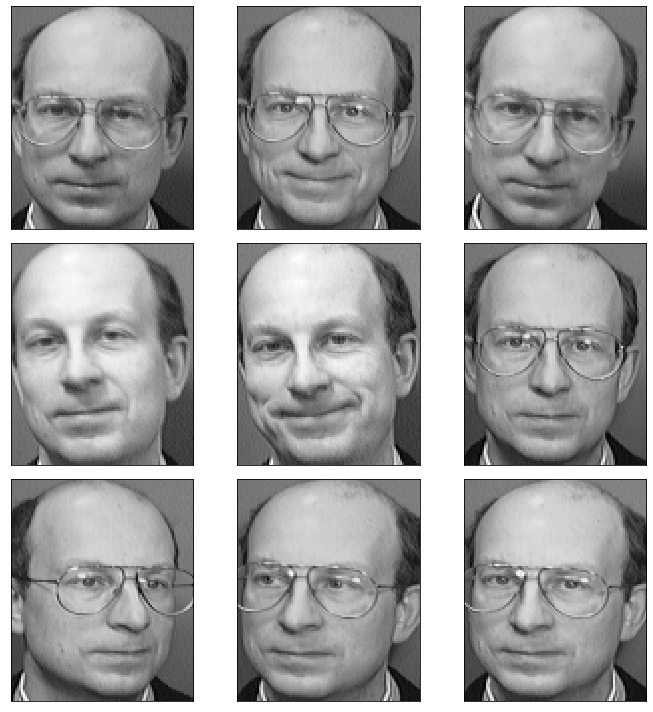

In [33]:
subject_idx = 4
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))
subject_img_idx = np.where(y_train==subject_idx)[0].tolist()

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = x_train[subject_img_idx[i]]
    img = img.reshape(img.shape[0], img.shape[1])
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

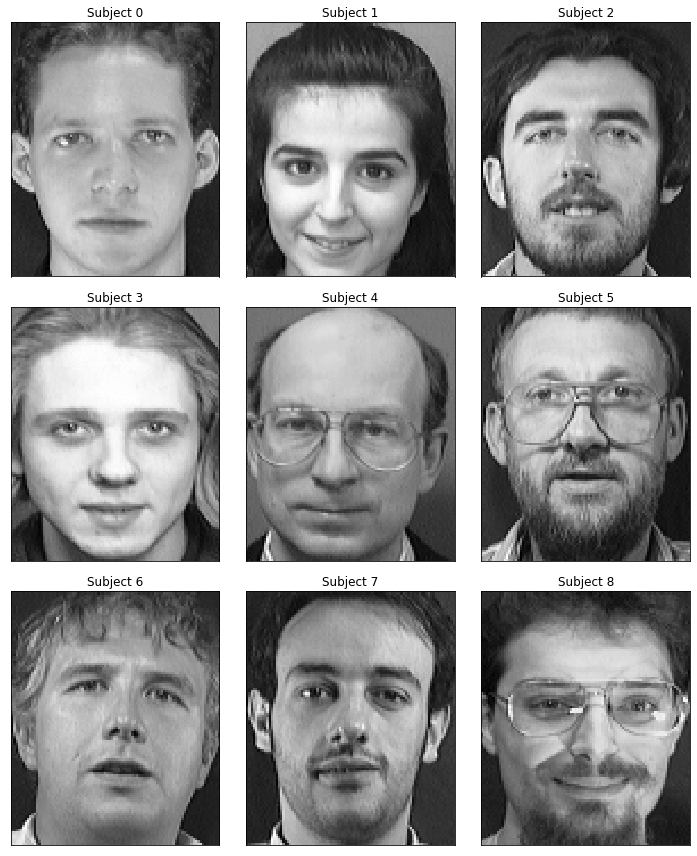

In [35]:
subjects = range(10)
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,
figsize=(10,12))
subject_img_idx = [np.where(y_train==i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = x_train[subject_img_idx[i]]
    img = img.reshape(img.shape[0], img.shape[1])
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Subject {}".format(i))

plt.tight_layout()
plt.show()

## Modeling

In [36]:
x_train.shape

(350, 112, 92, 1)